In [1]:
using Revise
using Molly
using Unitful
using ConstrainedDynamicsSimulator

[ Info: Precompiling ConstrainedDynamicsSimulator [c57ba902-cf0d-4687-8605-981b463e8666] (cache misses: include_dependency fsize change (4), wrong dep version loaded (2), mismatched flags (4))


In [6]:
# TODO: might still need to worry about boundary issues
ff_dir = joinpath(dirname(pathof(Molly)), "..", "data", "force_fields")
ff = MolecularForceField(joinpath.(ff_dir, ["ff99SBildn.xml", "tip3p_standard.xml"])...)
sys = System("dipeptide_nowater.pdb", ff; rename_terminal_res=false)

function phi_wrapper(sys, args...; kwargs...)
    rad2deg(torsion_angle(sys.coords[5], sys.coords[7], sys.coords[9],
                          sys.coords[15], sys.boundary))
end

function psi_wrapper(sys, args...; kwargs...)
    rad2deg(torsion_angle(sys.coords[7], sys.coords[9], sys.coords[15],
                          sys.coords[17], sys.boundary))
end

sys = System(
    "dipeptide_nowater.pdb",
    ff;
    rename_terminal_res=false,
    loggers=(
        writer=StructureWriter(100, "trajectory.pdb"),
        phi=GeneralObservableLogger(phi_wrapper, Float64, 100),
        psi=GeneralObservableLogger(psi_wrapper, Float64, 100),
    ),
    implicit_solvent="gbn2",
)

temp = 30.0u"K"
timestep = 0.002u"ps"
fric = 5000.0u"ps^-1"
simulator = CVConstrainedOverdampedLangevin(dt=timestep, T=temp, γ=fric, φ_grid=ConstrainedDynamicsSimulator.Dihedrals.φ_grid, φ_flat=ConstrainedDynamicsSimulator.Dihedrals.φ_flat)

CVConstrainedOverdampedLangevin{Quantity{Float64, 𝐓, Unitful.FreeUnits{(ps,), 𝐓, nothing}}, Quantity{Float64, 𝚯, Unitful.FreeUnits{(K,), 𝚯, nothing}}, Quantity{Float64, 𝐓⁻¹, Unitful.FreeUnits{(ps⁻¹,), 𝐓⁻¹, nothing}}, typeof(ConstrainedDynamicsSimulator.Dihedrals.φ_grid), typeof(ConstrainedDynamicsSimulator.Dihedrals.φ_flat)}(0.002 ps, 30.0 K, 5000.0 ps⁻¹, ConstrainedDynamicsSimulator.Dihedrals.φ_grid, ConstrainedDynamicsSimulator.Dihedrals.φ_flat, 1)

In [3]:
simulator = OverdampedLangevin(
    dt=timestep,
    temperature=temp,
    friction=fric,
)

OverdampedLangevin{Quantity{Float64, 𝐓, Unitful.FreeUnits{(ps,), 𝐓, nothing}}, Quantity{Float64, 𝚯, Unitful.FreeUnits{(K,), 𝚯, nothing}}, Quantity{Float64, 𝐓⁻¹, Unitful.FreeUnits{(ps⁻¹,), 𝐓⁻¹, nothing}}}(0.002 ps, 300.0 K, 5000.0 ps⁻¹, 1)

In [4]:
Molly.simulate!(sys, simulator, 100000)

System with 22 atoms, boundary CubicBoundary{Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}(Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}[3.4224000000000006 nm, 3.9133000000000004 nm, 3.3010999999999995 nm])

In [7]:
ConstrainedDynamicsSimulator.simulate!(sys, simulator, 100_000) # This will take a little while to run

progress = Progress(n_steps) = ProgressMeter.Progress(100000, 0, nothing, ProgressMeter.BarGlyphs('|', '█', ['▏', '▎', '▍', '▌', '▋', '▊', '▉'], ' ', '|'), ProgressMeter.ProgressCore(:green, "Progress: ", 0.1, true, 0, IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), false, 1, 0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (13748554496, 5322950192, 0)), 0, 1, false, false, 1.742309479721555e9, 1.742309479721555e9, 1.742309479721555e9))

Progress:   1%|▎                                        |  ETA: 0:00:19

Progress: 100%|█████████████████████████████████████████| Time: 0:00:19


System with 22 atoms, boundary CubicBoundary{Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}(Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}[3.4224000000000006 nm, 3.9133000000000004 nm, 3.3010999999999995 nm])

In [50]:
# TODO: We should include an equilibration period?
# TODO: We'll most likely need to enforce something like a SHAKE correction to avoid drifting issues.
# TODO: We need to investigate how multiprocessing works with Zigote and ForwardDIff in Julia

In [8]:
phi_values = values(sys.loggers.phi)
psi_values = values(sys.loggers.psi)

1001-element Vector{Float64}:
 160.7338408636881
 167.11705176614848
 166.8049408581201
 163.8627890379226
 163.9138436814719
 162.3190728945412
 162.58073656756932
 161.77990391040683
 164.31308052688553
 162.7743249018809
 163.88486400756432
 164.45325317423107
 165.96483619443282
   ⋮
 154.04681669398985
 152.6556196371238
 154.77087427936047
 154.34540619905187
 152.92367197075933
 155.2223233073695
 153.1417372724723
 154.1372381578087
 152.99217183330433
 154.32482660501995
 153.38234587745734
 155.76033953924195

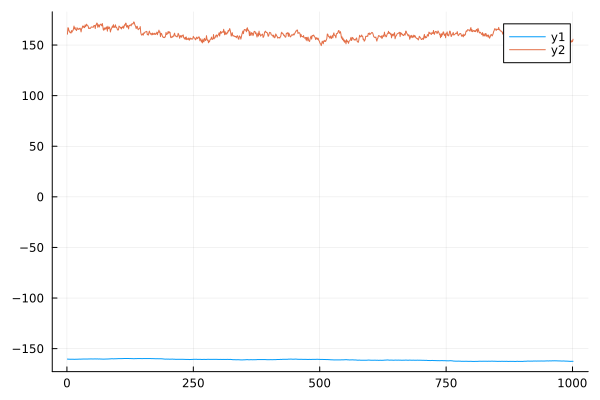

In [9]:
# This is with the default integrator

using Plots

plot(phi_values)
plot!(psi_values)